In [1]:
import sys
sys.path.insert(0, '..\\..\\frxas.py')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, report_fit

from frxas import hdf5_io
from frxas import models
from frxas import visualization

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
def chi_pattern(x, amp, aoo, gamma, ld, tg, f, L, po2, po2_ref):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    aoo : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    g =gamma
    w = 2 * np.pi * f
    ao = models.calc_ao(aoo, po2, po2_ref)

    chi = -amp /(ao * L * (1 / L +  g / ld * np.sqrt(1 + 1j * tg * w))) \
    * np.exp(-x / ld * np.sqrt(1 + 1j * tg * w))

    return chi

In [3]:
f1 = hdf5_io.get_all_datasets('July18_frXAS_v2', start_indices = [[4, 2, 2], [4, 6, 0], [1, 2]])
hdf5_io.close_frxas_file('July18_frXAS_v2')

In [4]:
x, data, frequencies, gases = hdf5_io.unpack_data(f1, kind='data_adj')

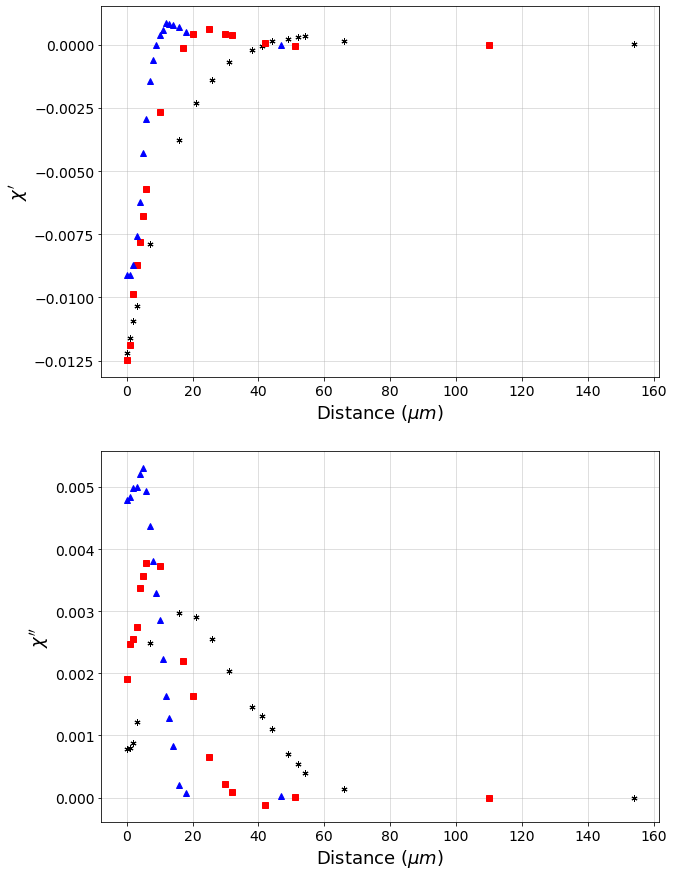

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

ax1, ax2 = visualization.plot_chi(axes, x[:3], data[:3])
# axes = visualization.plot_chi(axes, x[3:6], data[3:6])
# axes = visualization.plot_chi(axes, x[6:], data[6:])
# axes[1].set_xlim((420, 460))
# plt.show()

In [89]:
fit_params = Parameters()

for iy, y in enumerate(data):
    fit_params.add('amp_%i' % (iy+1), value=.04, min=0, max=1)
    fit_params.add('aoo_%i' % (iy+1), value=1.5, min=1, max=5)
    fit_params.add('gamma_%i' % (iy+1), value=1, min=0.0, max=200)
    fit_params.add('ld_%i' % (iy+1), value=15, min=0.0, max=200)
    fit_params.add('tg_%i' % (iy+1), value=.1, min=1e-3, max=10.0)
    fit_params.add('f_%i' % (iy+1), value=frequencies[iy], vary=False)
    fit_params.add('L_%i' % (iy+1), value=.65, vary=False)
    fit_params.add('po2_%i' % (iy+1), value=gases[iy], vary=False)
    fit_params.add('po2_ref_%i' % (iy+1), value=1, vary=False)

# Setting all aoo to be equal
for iy in np.arange(2, len(data)+1):
    fit_params['aoo_%i' % iy].expr = 'aoo_1'

# Setting other parameters within each dataset to be equal
for iy in np.arange(2, 4):
    fit_params['gamma_%i' % iy].expr = 'gamma_1'
    fit_params['ld_%i' % iy].expr = 'ld_1'
    fit_params['tg_%i' % iy].expr = 'tg_1'

for iy in np.arange(5, 7):
    fit_params['gamma_%i' % iy].expr = 'gamma_4'
    fit_params['ld_%i' % iy].expr = 'ld_4'
    fit_params['tg_%i' % iy].expr = 'tg_4'

for iy in np.arange(8, 9):
    fit_params['gamma_%i' % iy].expr = 'gamma_7'
    fit_params['ld_%i' % iy].expr = 'ld_7'
    fit_params['tg_%i' % iy].expr = 'tg_7'

In [90]:
mini=lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data, chi_pattern))

In [91]:
out = mini.minimize(method='least_squares')
print(out.redchi)
report_fit(out.params)

2.121254173494546e-07
[[Variables]]
    amp_1:      0.02901969 +/- 17208.7496 (59300246.68%) (init = 0.04)
    aoo_1:      1.25481800 +/- 482727.499 (38469921.55%) (init = 1.5)
    gamma_1:    4.09748259 +/- 0.46999725 (11.47%) (init = 1)
    ld_1:       21.4959919 +/- 1.36124561 (6.33%) (init = 15)
    tg_1:       0.84932688 +/- 0.11281179 (13.28%) (init = 0.1)
    f_1:        0.25 (fixed)
    L_1:        0.65 (fixed)
    po2_1:      0.01 (fixed)
    po2_ref_1:  1 (fixed)
    amp_2:      0.03123400 +/- 18521.8391 (59300247.01%) (init = 0.04)
    aoo_2:      1.25481800 +/- 482727.500 (38469921.63%) == 'aoo_1'
    gamma_2:    4.09748259 +/- 0.47000091 (11.47%) == 'gamma_1'
    ld_2:       21.4959919 +/- 1.36125186 (6.33%) == 'ld_1'
    tg_2:       0.84932688 +/- 0.11284430 (13.29%) == 'tg_1'
    f_2:        1 (fixed)
    L_2:        0.65 (fixed)
    po2_2:      0.01 (fixed)
    po2_ref_2:  1 (fixed)
    amp_3:      0.03872472 +/- 22963.8563 (59300246.62%) (init = 0.04)
    aoo_3:      1

In [85]:
out = mini.minimize(method='leastsq', params=out.params)
print(out.redchi)
report_fit(out.params)

2.1212541075273751e-07
[[Variables]]
    amp_1:      0.01383838 +/- 2221.67601 (16054452.09%) (init = 0.01383838)
    aoo_1:      1.00001333 +/- 16060.4013 (1606018.72%) (init = 1.000013)
    gamma_1:    4.09748095 +/- 0.46993739 (11.47%) (init = 4.097481)
    ld_1:       21.4960023 +/- 1.36361553 (6.34%) (init = 21.496)
    tg_1:       0.84932782 +/- 0.11284636 (13.29%) (init = 0.8493278)
    f_1:        0.25 (fixed)
    L_1:        0.65 (fixed)
    po2_1:      0.01 (fixed)
    po2_ref_1:  1 (fixed)
    amp_2:      0.01489430 +/- 2391.19785 (16054451.27%) (init = 0.0148943)
    aoo_2:      1.00001333 +/- 16060.4013 (1606018.72%) == 'aoo_1'
    gamma_2:    4.09748095 +/- 0.46993739 (11.47%) == 'gamma_1'
    ld_2:       21.4960023 +/- 1.36361553 (6.34%) == 'ld_1'
    tg_2:       0.84932782 +/- 0.11284636 (13.29%) == 'tg_1'
    f_2:        1 (fixed)
    L_2:        0.65 (fixed)
    po2_2:      0.01 (fixed)
    po2_ref_2:  1 (fixed)
    amp_3:      0.01846634 +/- 2964.66860 (16054448.85%)

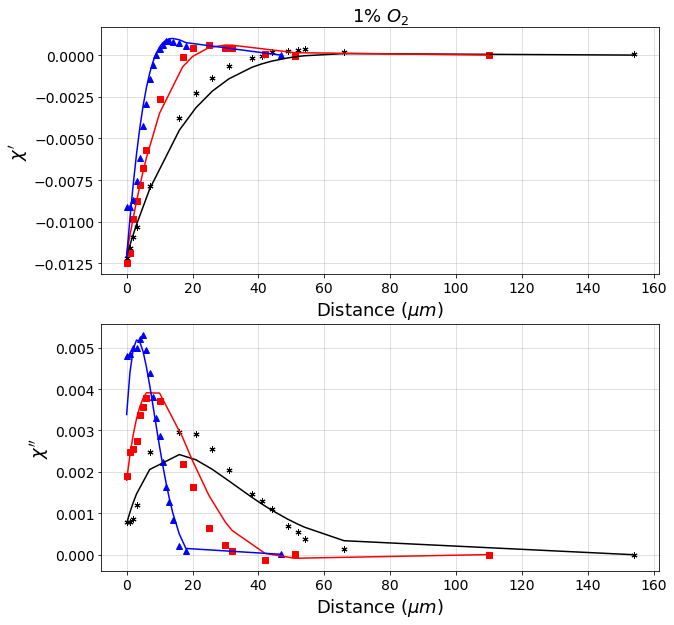

In [80]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0,3):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(0,3):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern), marker='')
    
axes[0].set_title('1% $O_2$', fontsize=18)
plt.show()

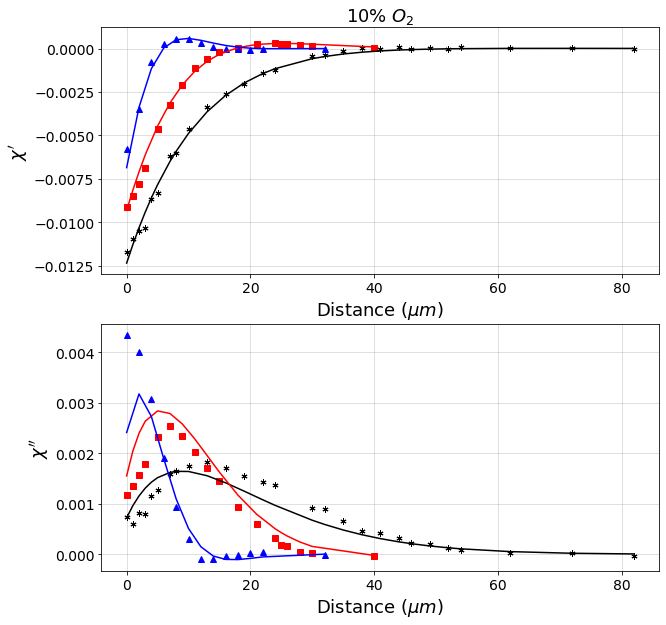

In [81]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(3,6):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(3,6):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern), marker='')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.show()

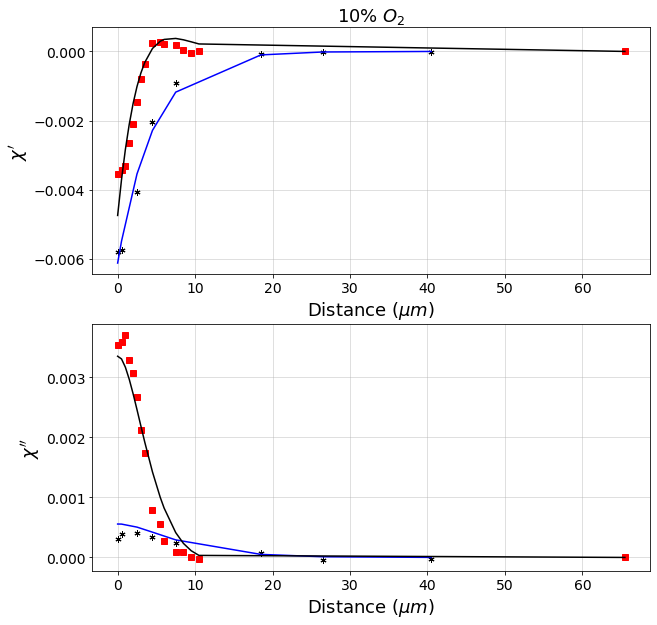

In [82]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(6,8):
    visualization.plot_chi(axes, x[iy], data[iy], ls='')
for iy in np.arange(6,8):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern), marker='')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.show()

Data clearly not fitting to the patterned model. Seemingly occurs because the real data isn't scaled to 1 (max values for real components are ~0.002)